# Churn Prediction - Final Project Dibimbing.id
---
by: Ikhwanul Muslimin

data from: [telecom_users](https://drive.google.com/file/d/1Vqty_NO9tsMaB8q5lu8lstTbH_7dnZ9b/view)

features explanation: [Dataset 1](https://docs.google.com/document/d/1cbwOTFzd0qzRWyJcr0YVc-1fTDs3D6aIVgd4megN06A/edit)


![picture](https://drive.google.com/uc?export=view&id=1opPlX_lsousbiFZTx76DyveMXfBf2ef9)

Any business wants to maximize the number of customers. To achieve this goal, it is important not only to try to attract new ones, but also to retain existing ones. 

Accordingly, predicting the churn, we can react in time and try to keep the client who wants to leave. Based on the data about the services that the client uses, we can make him a special offer, trying to change his decision to leave the operator. This will make the task of retention easier to implement than the task of attracting new users, about which we do not know anything yet.

You are provided with a dataset from a telecommunications company. The data contains information about almost six thousand users, their demographic characteristics, the services they use, the duration of using the operator's services, the method of payment, and the amount of payment.

The task is to analyze the data and predict the churn of users (to identify people who will and will not renew their contract). 

# Import Library and Load Data

In [ ]:
# import library for manipulating data
import numpy as np
import pandas as pd

# import library for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import library for machine learning
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# disable warning
import gc
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# mounted google drive
import google.colab as GC
GC.drive.mount('/content/drive')

# change folder
%cd '/content/drive/My Drive/datasets'

# read the data
df = pd.read_csv('telecom_users.csv')

Mounted at /content/drive
/content/drive/My Drive/datasets


# Exploratory Data Analysis

## General Information

In [ ]:
# display the first 5 rows of the data
df.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


In [ ]:
# simple data checking - get dataframe general information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5986 non-null   int64  
 1   customerID        5986 non-null   object 
 2   gender            5986 non-null   object 
 3   SeniorCitizen     5986 non-null   int64  
 4   Partner           5986 non-null   object 
 5   Dependents        5986 non-null   object 
 6   tenure            5986 non-null   int64  
 7   PhoneService      5986 non-null   object 
 8   MultipleLines     5986 non-null   object 
 9   InternetService   5986 non-null   object 
 10  OnlineSecurity    5986 non-null   object 
 11  OnlineBackup      5986 non-null   object 
 12  DeviceProtection  5986 non-null   object 
 13  TechSupport       5986 non-null   object 
 14  StreamingTV       5986 non-null   object 
 15  StreamingMovies   5986 non-null   object 
 16  Contract          5986 non-null   object 


## Column Explanation

* customerID - customer id
* gender - client gender (male / female)
* SeniorCitizen - is the client retired (1, 0)
* Partner - is the client married (Yes, No)
* tenure - how many months a person has been a client of the company
* PhoneService - is the telephone service connected (Yes, No)
* MultipleLines - are multiple phone lines connected (Yes, No, No phone service)
* InternetService - client's Internet service provider (DSL, Fiber optic, No)
* OnlineSecurity - is the online security service connected (Yes, No, No internet service)
* OnlineBackup - is the online backup service activated (Yes, No, No internet service)
* DeviceProtection - does the client have equipment insurance (Yes, No, No internet service)
* TechSupport - is the technical support service connected (Yes, No, No internet service)
* StreamingTV - is the streaming TV service connected (Yes, No, No internet service)
* StreamingMovies - is the streaming cinema service activated (Yes, No, No internet service)
* Contract - type of customer contract (Month-to-month, One year, Two year)
* PaperlessBilling - whether the client uses paperless billing (Yes, No)
* PaymentMethod - payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
* MonthlyCharges - current monthly payment
* TotalCharges - the total amount that the client paid for the services for the entire time
* Churn - whether there was a churn (Yes or No)


## Data Cleaning

### Delete Unnecessary Columns

In [ ]:
# drup unnamed and customerID columns
df.drop(['Unnamed: 0','customerID'],axis=1,inplace=True)

### Changing Data Type

In [ ]:
# change SeniorCitizen data type
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')
# change TotalCharges data type
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')

### Checking Null Values

In [ ]:
# count for null values in each columns
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        10
Churn                0
dtype: int64

In [ ]:
# replace nan values with the real price
df['TotalCharges'].fillna(df['tenure']*df['MonthlyCharges'],inplace=True)

### Checking Outlier

The outlier in <code>TotalCharges</code> is still understandable because it is still in range.

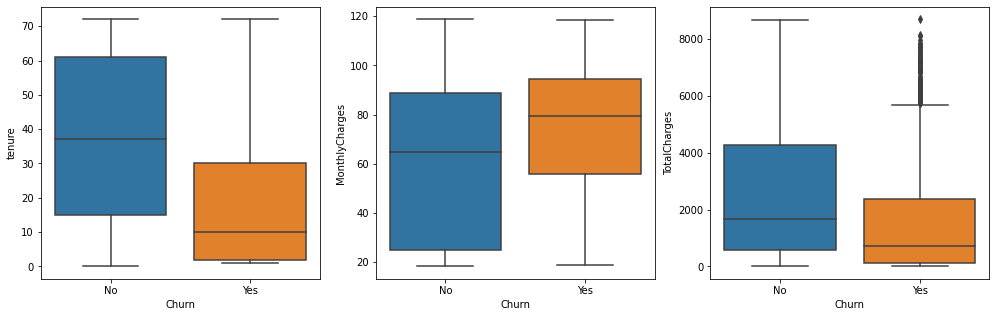

In [ ]:
# check outlier via boxplot
fig = plt.figure(figsize=(17,5))
ax1 = fig.add_subplot(1,3,1)
sns.boxplot(x='Churn',y='tenure',data=df,ax=ax1)
ax2 = fig.add_subplot(1,3,2)
sns.boxplot(x='Churn',y='MonthlyCharges',data=df,ax=ax2)
ax3 = fig.add_subplot(1,3,3)
sns.boxplot(x='Churn',y='TotalCharges',data=df,ax=ax3)

## Exploratory Analysis

### Overall Churn

Unbalanced target:

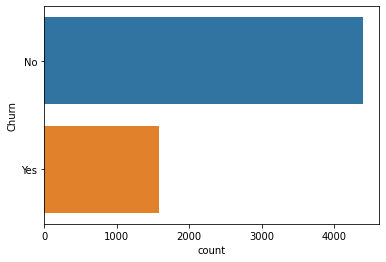

In [ ]:
sns.countplot(y='Churn',data=df)

In [ ]:
df.Churn.value_counts()

No     4399
Yes    1587
Name: Churn, dtype: int64

### Statistical Summary

* The longer the customer stays with us, the greater your total spend.
* Customers with higher monthly value, represent higher revenue.
* No relation between the months of the house, and the increase of the monthly payments.

In [ ]:
# check summary statistics
df.describe().round(2)

,tenure,MonthlyCharges,TotalCharges
count,5986.00,5986.00,5986.00
mean,32.47,64.80,2294.22
std,24.52,30.11,2274.16
min,0.00,18.25,0.00
25%,9.00,35.65,401.59
50%,29.00,70.40,1408.58
75%,56.00,89.90,3841.50
max,72.00,118.75,8684.80


<Figure size 1080x720 with 0 Axes>

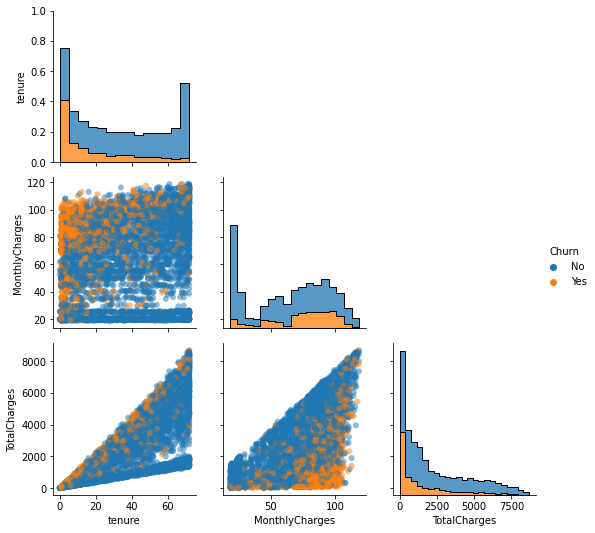

In [ ]:
# make new dataframe which consist of columns with numerics data type
df_num = df[['tenure','MonthlyCharges','TotalCharges','Churn']]

# function to hide upper triangle
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

# plot the relation in each columns
plt.figure(figsize = (15,10))
g = sns.PairGrid(df_num,hue='Churn')
g.map_lower(sns.scatterplot, alpha=0.5, edgecolor='none')
g.map_diag(sns.histplot, multiple="stack", element="step")
g.map_upper(hide_current_axis)
g.add_legend()

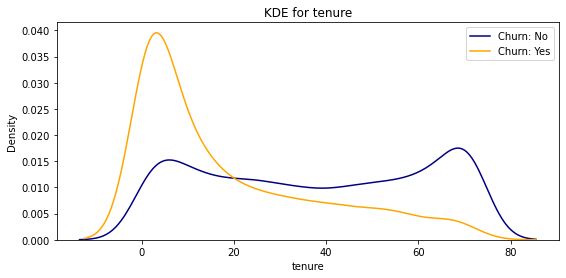

In [ ]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['Churn'] == 'No'][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['Churn'] == 'Yes'][feature].dropna(), color= 'orange', label= 'Churn: Yes')
    plt.legend()
kdeplot('tenure')

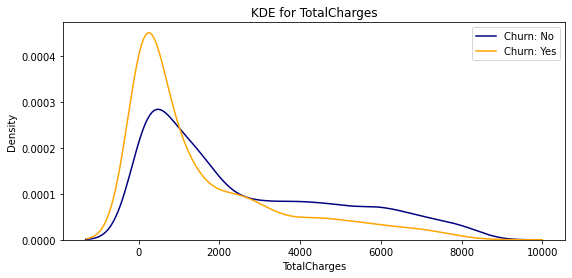

In [ ]:
kdeplot('TotalCharges')

From the plots above we can conclude that:
* Recent clients are more likely to churn
* Clients with higher MonthlyCharges are also more likely to churn
* Tenure and MonthlyCharges are probably important features

### Categorical Variable

In [ ]:
# check summary statistics
df.describe(include = 'object')

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986
unique,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,3050,5020,3082,4195,5396,2848,2627,2982,2605,2640,2960,2389,2356,3269,3528,2006,4399


#### Senior Citizen

* The elderly spend more in the company, it has a Total Amount higher, leave more revenue to the company.

In [ ]:
# check the summary statistics
df.groupby('SeniorCitizen').mean().round()

,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,,,
0,32.0,62.0,2201.0
1,33.0,80.0,2780.0


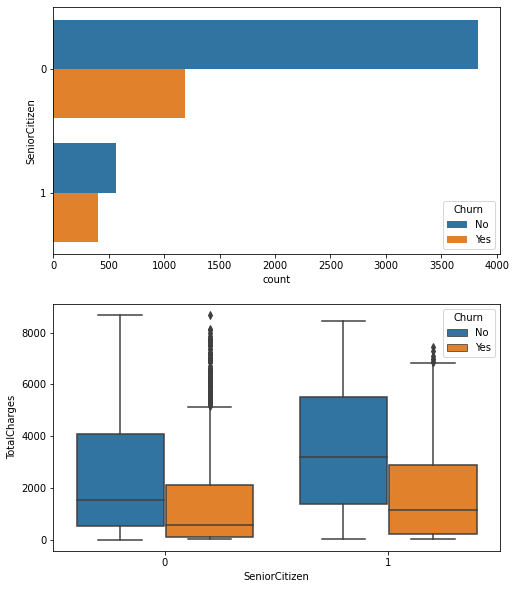

In [ ]:
# plotting
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(2,1,1)
sns.countplot(y=df['SeniorCitizen'],hue=df['Churn'],ax=ax1)
ax2 = fig.add_subplot(2,1,2)
sns.boxplot(x=df['SeniorCitizen'],y=df['TotalCharges'],hue=df['Churn'],ax=ax2)

#### Gender

* No behavior difference between women and men.

In [ ]:
# check the summary statistics
df.groupby('gender').mean().round()

,tenure,MonthlyCharges,TotalCharges
gender,,,
Female,32.0,65.0,2303.0
Male,33.0,64.0,2286.0


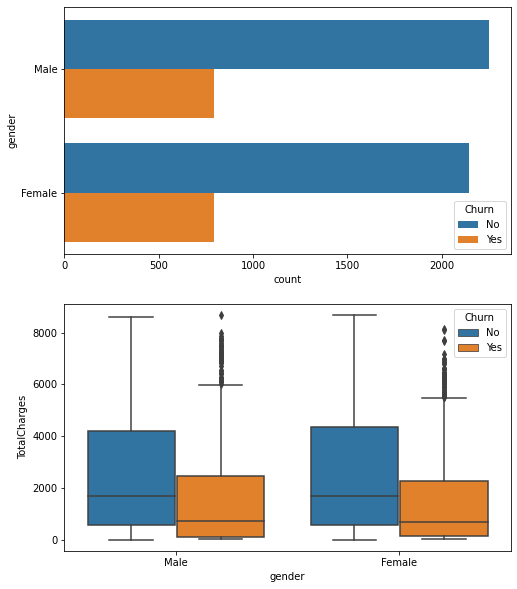

In [ ]:
# plotting
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(2,1,1)
sns.countplot(y=df['gender'],hue=df['Churn'],ax=ax1)
ax2 = fig.add_subplot(2,1,2)
sns.boxplot(x=df['gender'],y=df['TotalCharges'],hue=df['Churn'],ax=ax2)

#### Partner

* People with partner are very lucrative to the company, cause they stay more time and spent more money.

In [ ]:
# check the summary statistics
df.groupby('Partner').mean().round()

,tenure,MonthlyCharges,TotalCharges
Partner,,,
No,23.0,62.0,1585.0
Yes,42.0,68.0,3047.0


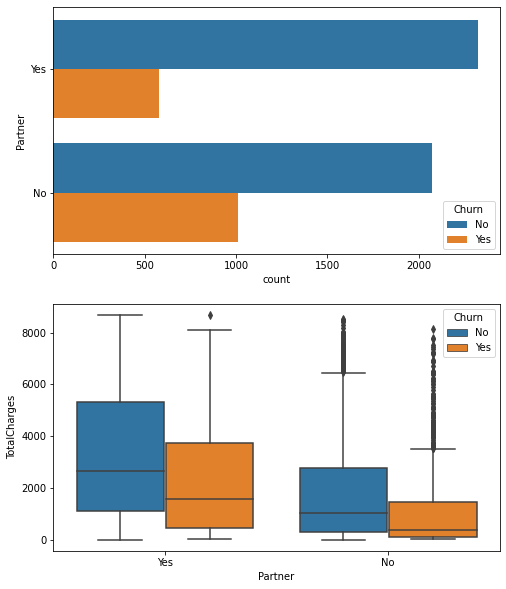

In [ ]:
# plotting
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(2,1,1)
sns.countplot(y=df['Partner'],hue=df['Churn'],ax=ax1)
ax2 = fig.add_subplot(2,1,2)
sns.boxplot(x=df['Partner'],y=df['TotalCharges'],hue=df['Churn'],ax=ax2)

#### Dependents

In [ ]:
# check the summary statistics
df.groupby('Dependents').mean().round()

,tenure,MonthlyCharges,TotalCharges
Dependents,,,
No,30.0,67.0,2201.0
Yes,39.0,59.0,2512.0


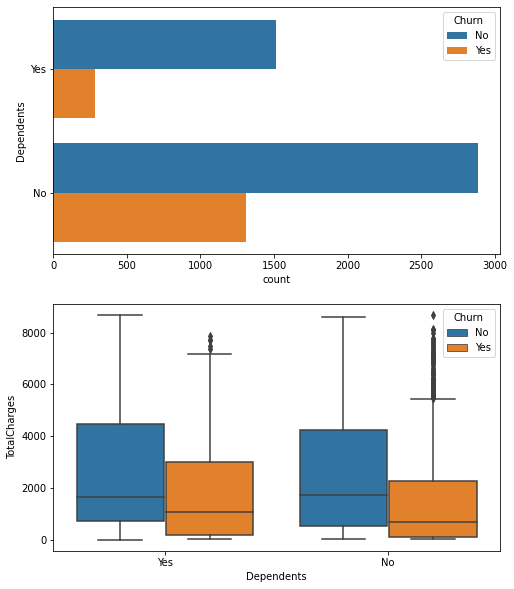

In [ ]:
# plotting
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(2,1,1)
sns.countplot(y=df['Dependents'],hue=df['Churn'],ax=ax1)
ax2 = fig.add_subplot(2,1,2)
sns.boxplot(x=df['Dependents'],y=df['TotalCharges'],hue=df['Churn'],ax=ax2)

#### Internet Service

* Clients without internet have a very low churn rate
* Customers with fiber are more probable to churn than those with DSL connection

In [ ]:
# check the summary statistics
df.groupby('InternetService').mean().round()

,tenure,MonthlyCharges,TotalCharges
InternetService,,,
DSL,33.0,58.0,2117.0
Fiber optic,33.0,92.0,3236.0
No,30.0,21.0,660.0


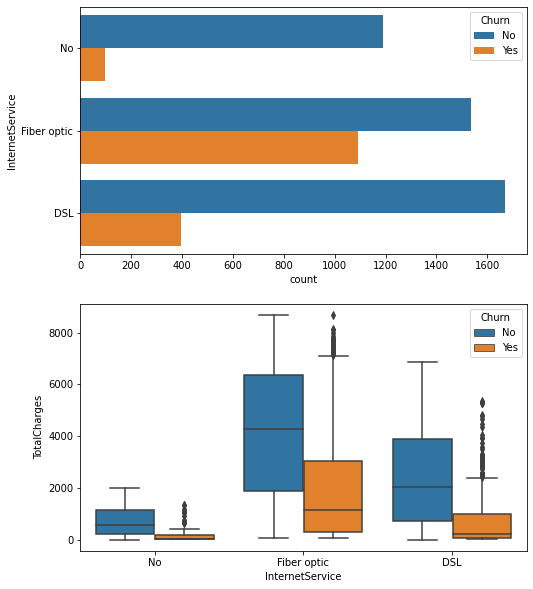

In [ ]:
# plotting
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(2,1,1)
sns.countplot(y=df['InternetService'],hue=df['Churn'],ax=ax1)
ax2 = fig.add_subplot(2,1,2)
sns.boxplot(x=df['InternetService'],y=df['TotalCharges'],hue=df['Churn'],ax=ax2)

#### Phone Service

* Few customers doesn't have phone service
* Customers with multiple lines have a slightly higher churn rate

In [ ]:
# check the summary statistics
df.groupby('PhoneService').mean().round()

,tenure,MonthlyCharges,TotalCharges
PhoneService,,,
No,32.0,42.0,1488.0
Yes,33.0,67.0,2382.0


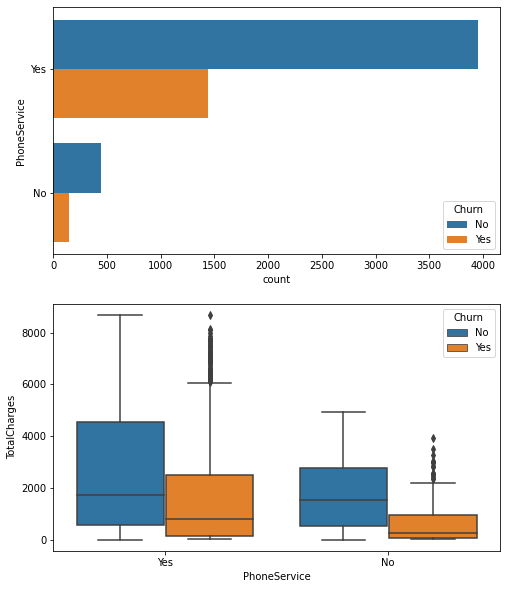

In [ ]:
# plotting
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(2,1,1)
sns.countplot(y=df['PhoneService'],hue=df['Churn'],ax=ax1)
ax2 = fig.add_subplot(2,1,2)
sns.boxplot(x=df['PhoneService'],y=df['TotalCharges'],hue=df['Churn'],ax=ax2)

#### Additional Services

* Customers with the first 4 additionals (security to tech support) are more unlikely to churn
* Streaming service is not predictive for churn

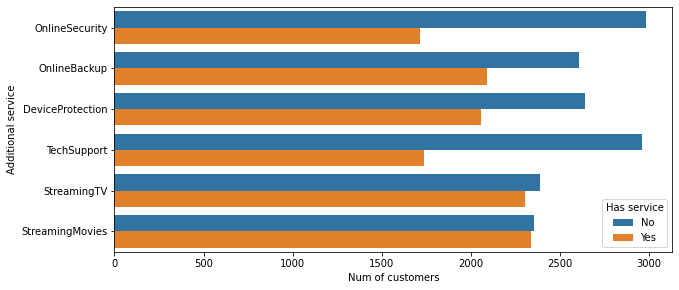

In [ ]:
add_service = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
df1 = pd.melt(df[df["InternetService"] != "No"][add_service]).rename({'value': 'Has service'}, axis=1)
plt.figure(figsize=(10, 4.5))
ax = sns.countplot(data=df1, y='variable', hue='Has service')
ax.set(xlabel='Num of customers', ylabel='Additional service')
plt.show()

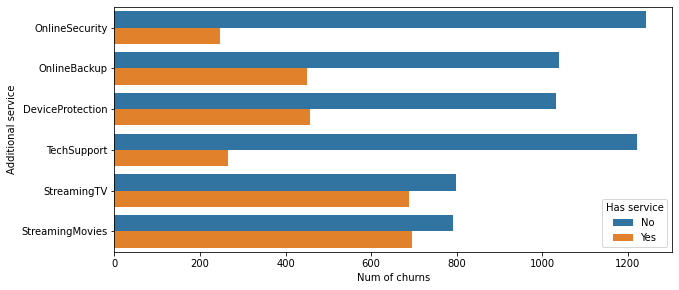

In [ ]:
plt.figure(figsize=(10, 4.5))
df1 = df[(df.InternetService != "No") & (df.Churn == "Yes")]
df1 = pd.melt(df1[add_service]).rename({'value': 'Has service'}, axis=1)
ax = sns.countplot(data=df1, y='variable', hue='Has service', hue_order=['No', 'Yes'])
ax.set(xlabel='Num of churns', ylabel='Additional service')
plt.show()

#### Contract

* Short term contracts have higher churn rates
* Longer contracts are more affected by higher monthly charges

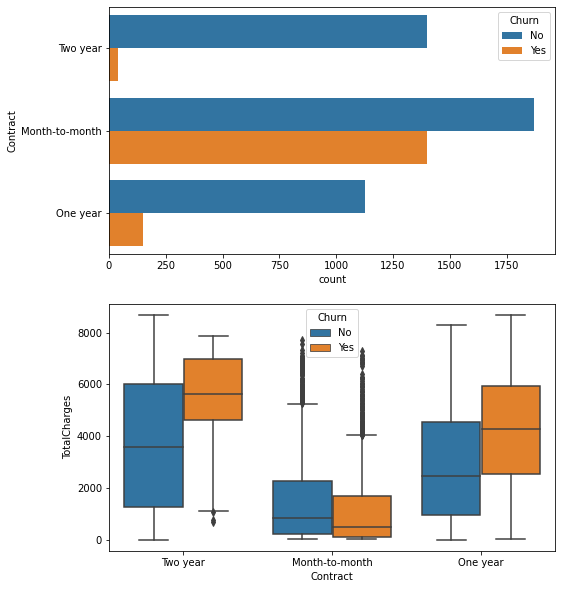

In [ ]:
# plotting
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(2,1,1)
sns.countplot(y=df['Contract'],hue=df['Churn'],ax=ax1)
ax2 = fig.add_subplot(2,1,2)
sns.boxplot(x=df['Contract'],y=df['TotalCharges'],hue=df['Churn'],ax=ax2)

#### Payment Method

* Customers with paperless billing are more probable to churn
* The preferred payment method is Electronic check. This method also has a very high churn rate
* Mailed checks have lower charges


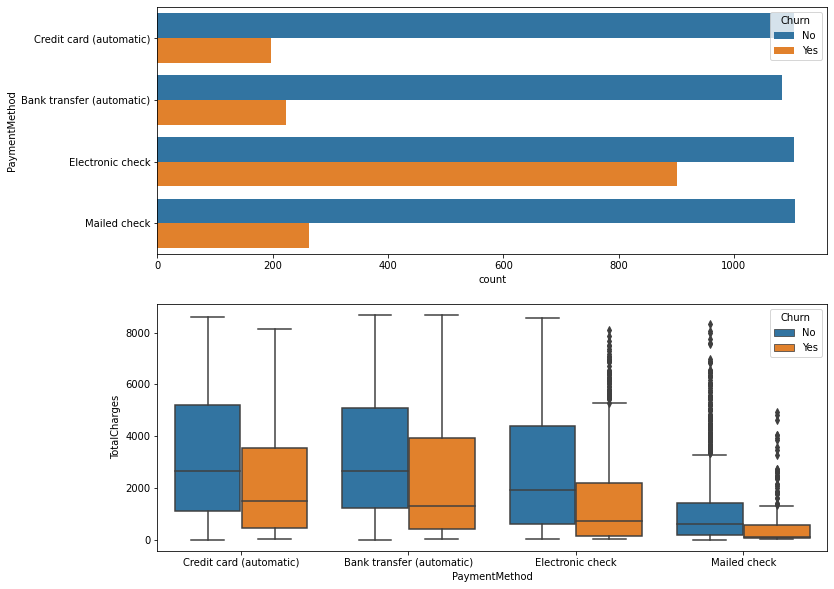

In [ ]:
# plotting
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(2,1,1)
sns.countplot(y=df['PaymentMethod'],hue=df['Churn'],ax=ax1)
ax2 = fig.add_subplot(2,1,2)
sns.boxplot(x=df['PaymentMethod'],y=df['TotalCharges'],hue=df['Churn'],ax=ax2)

### Features Correlation


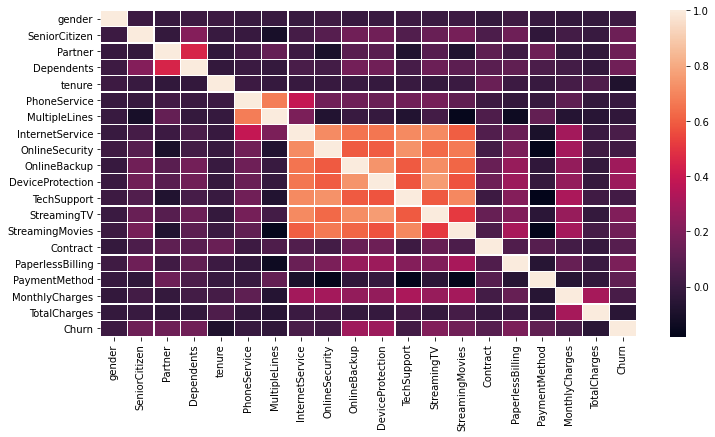

In [ ]:
plt.figure(figsize=(12, 6))
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.2)

# Churn Prediction

## Initialization

In [ ]:
# make a class to do all the steps for machine learning algorithm
class Model():
    def __init__(self, classifier, frame, metrics, fixed_params = {},
                 test_size=0.2, random_seed=29):
        self.estimator = classifier
        self.seed = random_seed
        self.metrics = metrics
        self.hyperparameters = {}
        self.fixed_params = fixed_params
        self.fixed_params['random_state'] = random_seed
        if classifier == KNeighborsClassifier:
            del self.fixed_params['random_state']

        # split the data into train and test data by test_size:1-test_size
        self.train, self.test = train_test_split(frame, test_size=test_size, random_state= self.seed)
        self.predictors = [c for c in self.train.columns if c not in ['customerID', 'Churn']]
    
    # use gridsearch to find the best parameter 
    def grid_search(self, fit_metric, params, num_folds=10):
        print(self.fixed_params)
        gs = GridSearchCV(self.estimator(**self.fixed_params), param_grid= params,
                          scoring=self.metrics, cv=num_folds, refit= fit_metric)
        gs.fit(self.train[self.predictors], self.train['Churn'])
        self.hyperparameters = gs.best_params_
        return [(m, gs.cv_results_['mean_test_{}'.format(m)][gs.best_index_]) for m in self.metrics]
    
    # train and predict using model
    def train_and_evaluate_test(self):
        params = {**self.hyperparameters, **self.fixed_params}
        clf = self.estimator(**params).fit(self.train[self.predictors], self.train['Churn'])
        y_pred = clf.predict(self.test[self.predictors])
        y_prob = clf.predict_proba(self.test[self.predictors])[:, 1]
        results = list()
        for m in self.metrics:
            if m == 'roc_auc':
                # for calculating roc auc we need the probability of target==1
                results.append((m, roc_auc_score(self.test['Churn'], y_prob)))
            else:
                # for the other metrics we can simply use the predicted label (0 or 1)
                results.append((m, eval("{}_score".format(m))(self.test['Churn'], y_pred)))
        return results

# function to print the results nicely
def print_result(results, sufix = ""):
    msg = ""
    for result in results:
        msg += "| {}: {:.4f} ".format(result[0], result[1])
    print("{}- {}".format(msg, sufix))

## Data Preprocessing

### Handling Categorical Columns

In [ ]:
# choosing categorical columns
categorical_cols = [c for c in df.columns if df[c].dtype == 'object']

# take the categorical columns of df
df_categorical = df[categorical_cols].copy()

# make dummy variable of categorical columns
for col in categorical_cols:
    if df_categorical[col].nunique() == 2:
        df_categorical[col], _ = pd.factorize(df_categorical[col])
    else:
        df_categorical = pd.get_dummies(df_categorical, columns=[col])

### Handling Numerical Columns

In [ ]:
# choosing numerical columns
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# take the standardization of numerical columns of df
df_std = pd.DataFrame(StandardScaler().fit_transform(df[numerical_cols].astype('float64')),
                      columns=numerical_cols)

## Finding Best Models

We are going to use 2 metrics for our models: ROC AUC score and accuracy.

In [ ]:
df_processed = pd.concat([df_std, df_categorical], axis=1)
metrics = ['roc_auc', 'accuracy']

df_processed.head()

,tenure,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1.612576,-1.351686,-0.246076,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0
1,0.470387,0.775360,0.738345,1,0,1,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0
2,0.225633,0.336999,0.253138,1,1,0,1,0,1,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0
3,-1.161310,-0.295635,-0.904022,0,0,1,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0
4,-1.242895,-0.376997,-0.956353,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


### 1. Logistic Regression

In [ ]:
# check the feature importance of logistic regression
model = LogisticRegression(random_state=29)

features = df_processed.drop(columns=['Churn'])

model.fit(features,df_processed['Churn'])

feature_importance=pd.DataFrame({'feature':list(features.columns),'feature_importance':[abs(i) for i in model.coef_[0]]})
feature_importance.sort_values('feature_importance',ascending=False)

,feature,feature_importance
0,tenure,1.389396
35,Contract_Two year,0.721334
33,Contract_Month-to-month,0.695899
2,TotalCharges,0.679768
13,InternetService_Fiber optic,0.526887
12,InternetService_DSL,0.407089
8,PaperlessBilling,0.312118
38,PaymentMethod_Electronic check,0.270948
15,OnlineSecurity_No,0.267426
1,MonthlyCharges,0.243595


In [ ]:
def logistic_regression(frame, grid):
    logit = Model(LogisticRegression, frame, metrics)
    print_result(logit.grid_search('roc_auc', grid), "cross-validation")
    print_result(logit.train_and_evaluate_test(), "test set")
    print("Best hyperparameters:", logit.hyperparameters)
logistic_regression(df_processed, {'C': np.logspace(-4, 4, 100, base=10)})

{'random_state': 29}
| roc_auc: 0.8414 | accuracy: 0.8045 - cross-validation
| roc_auc: 0.8443 | accuracy: 0.7913 - test set
Best hyperparameters: {'C': 2.782559402207126}


In [ ]:
logit_grid = {'C': np.linspace(0.02, 3, 150)}
logistic_regression(df_processed, logit_grid)

{'random_state': 29}
| roc_auc: 0.8414 | accuracy: 0.8047 - cross-validation
| roc_auc: 0.8443 | accuracy: 0.7905 - test set
Best hyperparameters: {'C': 2.62}


### 2. Support Vector Machine (SVM)

#### RBF Kernel

Tuning the hyperparameters C and gamma.

In [ ]:
def svc_rbf(frame, grid):
    rbf = Model(SVC, frame, metrics, fixed_params= {'kernel': 'rbf', 'probability': True})
    print_result(rbf.grid_search('roc_auc', grid, num_folds=4), "cross-validation")
    print_result(rbf.train_and_evaluate_test(), "test set")
    print("Best hyperparameters:", rbf.hyperparameters)

grid_rbf =  {'C': np.logspace(-4, 1, 10, base=2), 'gamma': np.logspace(-6, 2, 10, base=2)}
svc_rbf(df_processed, grid_rbf)

{'kernel': 'rbf', 'probability': True, 'random_state': 29}
| roc_auc: 0.8312 | accuracy: 0.7550 - cross-validation
| roc_auc: 0.8333 | accuracy: 0.7846 - test set
Best hyperparameters: {'C': 0.0625, 'gamma': 0.015625}


#### Linear Kernel

Tuning the regularization parameter.

In [ ]:
def svc_linear(frame, grid):
    linear = Model(SVC, frame, metrics, fixed_params={'kernel': 'linear', 'probability': True})
    print_result(linear.grid_search('roc_auc', grid), "cross-validation")
    print_result(linear.train_and_evaluate_test(), "test set")
    print("Best hyperparameters:", linear.hyperparameters)
    
svc_linear(df_processed, {'C': np.logspace(-4, 1, 100, base=10)})

{'kernel': 'linear', 'probability': True, 'random_state': 29}
| roc_auc: 0.8330 | accuracy: 0.7368 - cross-validation
| roc_auc: 0.8327 | accuracy: 0.7270 - test set
Best hyperparameters: {'C': 0.00020092330025650479}


#### Polynomial Kernel

In [ ]:
def svc_poly(frame, grid):
    poly_svc = Model(SVC, frame, metrics, fixed_params={'kernel': 'poly', 'probability': True})
    print_result(poly_svc.grid_search('roc_auc', grid), "cross-validation")
    print_result(poly_svc.train_and_evaluate_test(), "test set")
    print("Best hyperparameters:", poly_svc.hyperparameters)
    
svc_poly(df_processed, {'C': np.logspace(-5, 1, 30, base=2), 'degree': [2, 3]})

{'kernel': 'poly', 'probability': True, 'random_state': 29}
| roc_auc: 0.8210 | accuracy: 0.7964 - cross-validation
| roc_auc: 0.8271 | accuracy: 0.7947 - test set
Best hyperparameters: {'C': 0.03125, 'degree': 2}


### 3. Nearest Neighbors Classifier

In [ ]:
def knn_clf(frame, grid):
    knn = Model(KNeighborsClassifier, frame, metrics)
    print_result(knn.grid_search('roc_auc', grid), "cross-validation")
    print_result(knn.train_and_evaluate_test(), "test set")
    print("Best hyperparameters:", knn.hyperparameters)
    
knn_clf(df_processed, {'n_neighbors': [i for i in range(10, 50, 2)]})

{}
| roc_auc: 0.8285 | accuracy: 0.7957 - cross-validation
| roc_auc: 0.8351 | accuracy: 0.7855 - test set
Best hyperparameters: {'n_neighbors': 44}


## Feature Engineering

### Remove Useless Columns

In [ ]:
# drop gender
features1 = ['gender']

# drop 'no internet'
features2 = ['OnlineSecurity_No internet service', 'OnlineBackup_No internet service',
             'DeviceProtection_No internet service', 'TechSupport_No internet service',
             'StreamingTV_No internet service', 'StreamingMovies_No internet service']

# drop PhoneService because it is already in MultipleLines
features3 = ['PhoneService']

# bring them together
features = np.concatenate([features1,features2,features3])

In [ ]:
# cross-validation - evaluation
df_processed.drop(features, axis=1, inplace=True)
logit = Model(LogisticRegression, df_processed, metrics)
print_result(logit.grid_search('roc_auc', logit_grid), "cross-validation")
print_result(logit.train_and_evaluate_test(), "test set")

{'random_state': 29}
| roc_auc: 0.8417 | accuracy: 0.8045 - cross-validation
| roc_auc: 0.8443 | accuracy: 0.7905 - test set


### Add New Column

#### Checking Performance of Each Column

In [ ]:
# difference between TotalCharges and the tenure multiplied by monthly charges
df_tmp = df_processed.copy()
df_tmp['charges_difference'] = df_tmp['TotalCharges'] - df_tmp['tenure']*df_tmp['MonthlyCharges']
logit = Model(LogisticRegression, df_tmp, metrics)
print_result(logit.grid_search('roc_auc', logit_grid), "cross-validation")

{'random_state': 29}
| roc_auc: 0.8417 | accuracy: 0.8045 - cross-validation


In [ ]:
# tenure multiplied by monthly charges
df_tmp = df_processed.copy()
df_tmp['tenure*charges'] = df_tmp['tenure']*df_tmp['MonthlyCharges']
logit = Model(LogisticRegression, df_tmp, metrics)
print_result(logit.grid_search('roc_auc', logit_grid), "cross-validation")

{'random_state': 29}
| roc_auc: 0.8417 | accuracy: 0.8047 - cross-validation


In [ ]:
# ratio between the tenure multiplied by monthly charges and TotalCharges
df_tmp = df_processed.copy()
df_tmp['charges_ratio'] = df_tmp['tenure']*df_tmp['MonthlyCharges'] / (df_tmp['TotalCharges'] + 1)
logit = Model(LogisticRegression, df_tmp, metrics)
print_result(logit.grid_search('roc_auc', logit_grid), "cross-validation")

{'random_state': 29}
| roc_auc: 0.7202 | accuracy: 0.7227 - cross-validation


#### Choose The Best Column

In [ ]:
# add feature
df_processed['tenure*charges'] = df_processed['tenure']*df_processed['MonthlyCharges']
logit = Model(LogisticRegression, df_processed, metrics)
print_result(logit.grid_search('roc_auc', logit_grid), "cross-validation")
print_result(logit.train_and_evaluate_test(), "test set")

{'random_state': 29}
| roc_auc: 0.8417 | accuracy: 0.8047 - cross-validation
| roc_auc: 0.8445 | accuracy: 0.7905 - test set


### Polynomial Features

#### Checking Performance of Each Degree

In [ ]:
def add_polynomial_features(frame, poly_degree=2, interaction=False):
    # generate polynomials for the four numerical features
    poly = PolynomialFeatures(degree=poly_degree, interaction_only=interaction, include_bias=False)
    poly_features = poly.fit_transform(frame[['tenure', 'MonthlyCharges', 'TotalCharges','tenure*charges']])
    # convert to dataframe and drop the repeated columns
    df_poly = pd.DataFrame(poly_features, columns=poly.get_feature_names())
    return pd.concat([frame, df_poly.drop(['x0', 'x1', 'x2'], axis=1)], axis=1)

# try a few different options for polynomial features
for degree in range(2, 6):
    for interaction in [True, False]:
        df_poly = add_polynomial_features(df_processed, degree, interaction)
        print("Degree: {}, interaction only: {}, data shape: {}"
              .format(degree, interaction, df_poly.shape))
        logit = Model(LogisticRegression, df_poly, metrics)
        print_result(logit.grid_search('roc_auc', logit_grid), "cross-validation")
        del df_poly; gc.collect()

Degree: 2, interaction only: True, data shape: (5986, 41)
{'random_state': 29}
| roc_auc: 0.8444 | accuracy: 0.8097 - cross-validation
Degree: 2, interaction only: False, data shape: (5986, 45)
{'random_state': 29}
| roc_auc: 0.8442 | accuracy: 0.8095 - cross-validation
Degree: 3, interaction only: True, data shape: (5986, 45)
{'random_state': 29}
| roc_auc: 0.8446 | accuracy: 0.8062 - cross-validation
Degree: 3, interaction only: False, data shape: (5986, 65)
{'random_state': 29}
| roc_auc: 0.8462 | accuracy: 0.8045 - cross-validation
Degree: 4, interaction only: True, data shape: (5986, 46)
{'random_state': 29}
| roc_auc: 0.8446 | accuracy: 0.8068 - cross-validation
Degree: 4, interaction only: False, data shape: (5986, 100)
{'random_state': 29}
| roc_auc: 0.8458 | accuracy: 0.8051 - cross-validation
Degree: 5, interaction only: True, data shape: (5986, 46)
{'random_state': 29}
| roc_auc: 0.8446 | accuracy: 0.8068 - cross-validation
Degree: 5, interaction only: False, data shape: (59

#### Choose The Best Degree

In [ ]:
# take only third degree polynomial
df_processed = add_polynomial_features(df_processed, 3, False)
logit = Model(LogisticRegression, df_processed, metrics)
print_result(logit.grid_search('roc_auc', logit_grid), "cross-validation")
print_result(logit.train_and_evaluate_test(), "test set")

{'random_state': 29}
| roc_auc: 0.8462 | accuracy: 0.8045 - cross-validation
| roc_auc: 0.8472 | accuracy: 0.7930 - test set


# Conclusion

So, by using feature engineering, we can increase our ROC AUC score from 0.8414 to 0.8472 using Logistic Regression.